In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import rasterio

from skimage import measure

import pandas as pd
#from scipy import stats

# An Explanation

Many times in a raster, we want to find connected components in the image to identify descrete objects.  We call this labeling, and can find it in several Python packages, including SciPy's ndimage, scikit-image's measure toolbox, and OpenCV.  Many other computer vision packages feature this functionality as well.

The idea is that we search the image for pixels that are adjacent to one another to form larger regions.  We usually count adjancency, or neighbors, in two ways - either a 4-way system of neighbors, where pixels to the top, bottom, left, and right are considered neighbors, or 8-way, in which pixels diagnonally to a central pixel are included as well.

Regions are first found or labelled (<i>label</i>), and then secondarily we can find properties about these regions (<i>regionprops</i>) including the area, coordiantes, perimeter, and many, many other qualities.

Solving the problem in raster-space, rather than transforming to vector-space first, produces very impressive efficiency gains.

# A simple example

### Generate test data

We can start by generating a small raster of random data, and then applying a threshold to turn it into a binary image.  A dilation afterward will help the individual regions grow into one another to form larger regions of connected components.

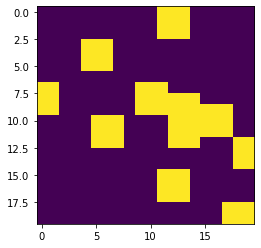

In [4]:
# We can create a simple raster of random, grouped data to do some initial testing.

X = np.random.rand(20,20)
X = X < .02
X = ndi.morphology.binary_dilation(X,np.ones((3,3)))
plt.imshow(X)

### Label the image and calculate properties

In [5]:
# We can label this dataset, and display the groupings.

# Categorize raster based on this distance threshold
X_labeled, num_features = measure.label(X,connectivity=2,return_num=True)
props = measure.regionprops_table(X_labeled,properties=['label','area','coords'])

print('There are',num_features,'features in the above image.')

There are 7 features in the above image.


<B>Note that measure.regionprops_table is new in scikit-image v16.  Similar results can be had with "regionprops" instead, which outputs a list.</b>

### Inspect the output

The output of the labeling process is an array of equal size to the input, with each region given a unique integer ID.<BR><BR>These ids increase left to right, and top to bottom.

In [6]:
print(X_labeled)

[[0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 3 0 0 0 0 0 0 0 4 4 4 0 0 0 0 0 0 0 0]
 [3 3 0 0 0 0 0 0 0 4 4 4 4 4 4 0 0 0 0 0]
 [3 3 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 0 0]
 [0 0 0 0 0 5 5 5 0 0 0 0 4 4 4 4 4 4 0 0]
 [0 0 0 0 0 5 5 5 0 0 0 0 4 4 4 4 4 4 0 0]
 [0 0 0 0 0 5 5 5 0 0 0 0 4 4 4 0 0 0 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 6 6 6 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 6 6 6 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 6 6 6 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 7 7]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 7 7]]


We can also view this array as an image, first creating a randomized colormap to distinguish the labels better.

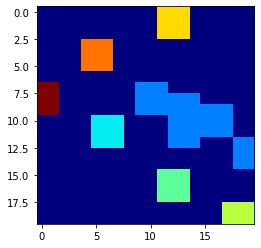

In [7]:
# Create random colormap for easier viewing
vals = np.linspace(.25,1,num_features+1)
np.random.shuffle(vals)
vals[0] = 0
cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))

# Show the image
plt.imshow(X_labeled,cmap=cmap)

### Inspecting and using region properties

In [8]:
# What are the areas (in pixels) of the regions?
print(props['area'])

[ 9  9  6 39  9  9  6]


In [9]:
# Display the first 10 coordinates of the first region:
props['coords'][0][:10]

array([[ 0, 11],
       [ 0, 12],
       [ 0, 13],
       [ 1, 11],
       [ 1, 12],
       [ 1, 13],
       [ 2, 11],
       [ 2, 12],
       [ 2, 13]], dtype=int64)

### Creating masks from region properties

Text(0.5, 1.0, 'Colored by area')

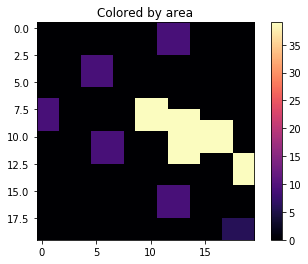

In [10]:
### Create a mask of region areas:

mask = X_labeled.copy()
for i in range(num_features):
    item_index = props['label'][i]
    this_area = props['area'][i]
    mask[mask==item_index] = this_area
    
plt.imshow(mask,cmap='magma')
plt.colorbar()
plt.title('Colored by area')

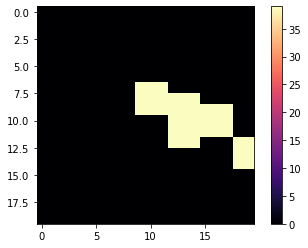

In [11]:
### Remove anything with an area smaller than a threshold

threshold = 10
mask[mask<threshold] = 0

plt.imshow(mask,cmap='magma')
plt.colorbar()

### Filtering based on attribute data

Alternatively, we could treat the labelled raster in an analogous way to an FID in a shapefile (or index value more generally) and make a selection this way.  It's helpful here to render the table as a pandas dataframe.  <strong>This is generally the preferred method, as it's often much, much faster.</strong>

In [12]:
df = pd.DataFrame(props)
df

,label,area,coords
0,1,9,"[[0, 11], [0, 12], [0, 13], [1, 11], [1, 12], ..."
1,2,9,"[[3, 4], [3, 5], [3, 6], [4, 4], [4, 5], [4, 6..."
2,3,6,"[[7, 0], [7, 1], [8, 0], [8, 1], [9, 0], [9, 1]]"
3,4,39,"[[7, 9], [7, 10], [7, 11], [8, 9], [8, 10], [8..."
4,5,9,"[[10, 5], [10, 6], [10, 7], [11, 5], [11, 6], ..."
5,6,9,"[[15, 11], [15, 12], [15, 13], [16, 11], [16, ..."
6,7,6,"[[18, 17], [18, 18], [18, 19], [19, 17], [19, ..."


These values meet the criteria: [1 2 3 5 6 7]


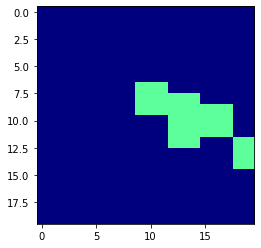

In [13]:
threshold = 10

# Find indices that meet the criteria
idx = df[df['area']<threshold]['label'].values
print('These values meet the criteria:',idx)

# Replace these values with zero
mask = X_labeled.copy()
mask[np.isin(mask,idx)] = 0

# View the mask
vals = np.linspace(.25,1,num_features+1)
np.random.shuffle(vals)
vals[0] = 0
cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))
plt.imshow(mask,cmap=cmap)

# Surface Mine Data

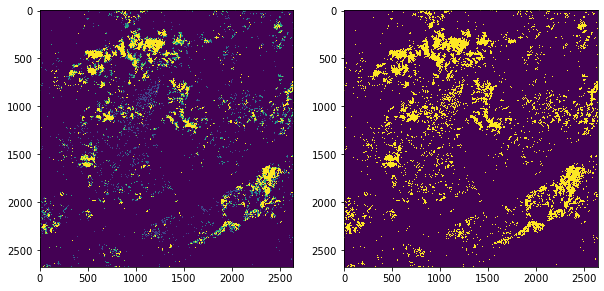

In [14]:
with rasterio.open('data/surface_mine_raster_original_active_sum_clipped.tif') as src:
    Z = src.read(1)
    Zt = src.transform
    cellsize = Zt[0]
    profile = src.profile

Z_binary = Z > 0
    
# The original has integer values representing counts, but just show as a binary mask
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(Z,vmin=0,vmax=5)
plt.subplot(122)
plt.imshow(Z_binary)

### Find regions

In [15]:
Z_labeled, num_features = measure.label(Z_binary,connectivity=2,return_num=True)
props = measure.regionprops_table(Z_labeled,properties=['label','area','centroid'])

# How many regions?
print('There were',num_features,'regions')

There were 19782 regions


In [16]:
# Many of these are very small!  

threshold=5  # pixels
num_low_area = np.sum(props['area']<threshold)

print(num_low_area,'have an area less than',threshold)

14065 have an area less than 5


### Create a copy of the original, but only with areas above a threshold retained

102 meet the criteria.


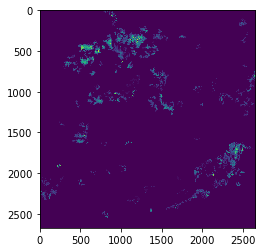

In [17]:
threshold = 1000  # in pixels

df = pd.DataFrame(props)
idx = df[df['area']>=threshold]['label'].values
print(len(idx),'meet the criteria.')

Z_filtered = np.zeros(np.shape(Z),dtype=Z.dtype)
mask = np.isin(Z_labeled,idx)
Z_filtered[mask] = Z[mask]

df_filtered = df[df['area']>=threshold]

plt.imshow(Z_filtered)

### Write outputs

In [18]:
# Write this out to disk

with rasterio.open('filtered.tif', 'w', **profile) as dst:
    dst.write(Z_filtered, 1)

In [20]:
# Centroids are given in image space, and need to be transformed to map coordinates
df_filtered['centroid_x'], df_filtered['centroid_y'] = Zt  * (df_filtered['centroid-1'],df_filtered['centroid-0'])

# Write out the results
df_filtered.to_csv('centroids.csv',columns=['centroid_x','centroid_y','area'],index=False)

c:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
